In [1]:
%%capture 
import radd
from radd import build
# takes a while for mpl to build font-cache
%matplotlib inline 

In [2]:
# read in example dataframe 
data = radd.load_example_data()
# baseline (bsl) and caution (pnl) conditions in 'Cond' column
data.head()

,idx,Cond,ttype,choice,response,acc,rt,ssd
0,28,bsl,go,go,1,1,0.59853,1000
1,28,bsl,go,go,1,1,0.52017,1000
2,28,bsl,go,go,1,1,0.54513,1000
3,28,bsl,go,go,1,1,0.57159,1000
4,28,bsl,go,go,1,1,0.50522,1000


In [3]:
# initiate dependent process model with dynamic gain (kind = 'xdpm')
# (change kind='dpm' for model with no dynamic gain signal)
# drift-rate (v) depends on Baseline and Caution levels of 'Cond' variable
dpm = build.Model(kind='xdpm', data=data, depends_on={'v':'Cond'}, fit_on='average')

# Animation of Dependent Process Model

In [5]:
# Initial state of Stop process (red) depends on current strength of Go activation (green)
# Assumes Stop signal efficacy at later SSDs diminishes as the state of the Go process 
# approaches the execution threshold (upper bound). pink lines denote t=SSD, blue is trial deadline
radd.load_dpm_animation()

# Model's observed dataframe (model.observedDF)
* **idx**: subject ID
* **Cond**: Baseline(bsl)/Caution(pnl) (could be any experimental condition of interest) 
* **Acc**: Accuracy on "go" trials
* **200 - 400**: SSD conditions (in ms)
* **c10 - c90**: 10th - 90th RT quantiles for correct responses
* **e10 - e90**: 10th - 90th RT quantiles for error responses

In [6]:
# look at first five rows of observed dataframe
dpm.observedDF.head()

,idx,Cond,acc,200,250,300,350,400,c10,c30,c50,c70,c90,e10,e30,e50,e70,e90
0,28,bsl,0.99174,1.0,1.0,0.95,0.60,0.00,0.50509,0.53191,0.55812,0.56643,0.59818,0.49608,0.53166,0.53187,0.54585,0.56744
1,28,pnl,0.97521,1.0,1.0,0.95,0.80,0.10,0.51767,0.54517,0.57184,0.59735,0.61186,0.51983,0.54525,0.55858,0.57181,0.60212
2,29,bsl,0.99174,1.0,1.0,1.00,0.90,0.00,0.52504,0.54513,0.55850,0.57196,0.59844,0.52676,0.54510,0.55845,0.57092,0.59019
3,29,pnl,0.96694,1.0,1.0,1.00,0.75,0.35,0.53145,0.55997,0.58502,0.59849,0.62498,0.53144,0.54477,0.55171,0.57507,0.59804
4,30,bsl,0.94215,1.0,1.0,1.00,0.80,0.25,0.52978,0.57188,0.59812,0.61175,0.63843,0.53607,0.56057,0.58535,0.60980,0.62076


# Global Optimization Parameters (set_basinparams)

* Sample 5000 parameters sets, perform global optimization on best 3, 
    choose set w/ lowest global min
    * **nsamples** = 5000
    * **ninits** = 5
    * **init_sample_method** = "best"
    

* Set basinhopping step-size to .1 
    * **stepsize** = .1
    * see HopStep class in radd.fit & radd.tools.theta.get_stepsize_scalars()


* Liberal acceptance criteria for demo purposes, exit after 20 accepted steps w/o new global min 
    * **tol**=**xtol**=**ftol** = 1e-5 (.00001)
    * **nsuccess** = 30


# Local Optimization Parameters (set_fitparams)

* Liberal acceptance criteria for Nelder-Mead Simplex
    * **tol** = 1e-5 (.00001)

In [25]:
dpm.set_basinparams(nsamples=5000, ninits=5, init_sample_method="best", stepsize=.1, tol=1e-5, nsuccess=40)
dpm.set_fitparams(tol=1e-5)

Finished Hopping Around:
GLOBAL MIN = 0.001312401
Optimization terminated successfully.
         Current function value: 0.001123
         Iterations: 178
         Function evaluations: 357
Optimization terminated successfully.
         Current function value: 0.002656
         Iterations: 30
         Function evaluations: 75


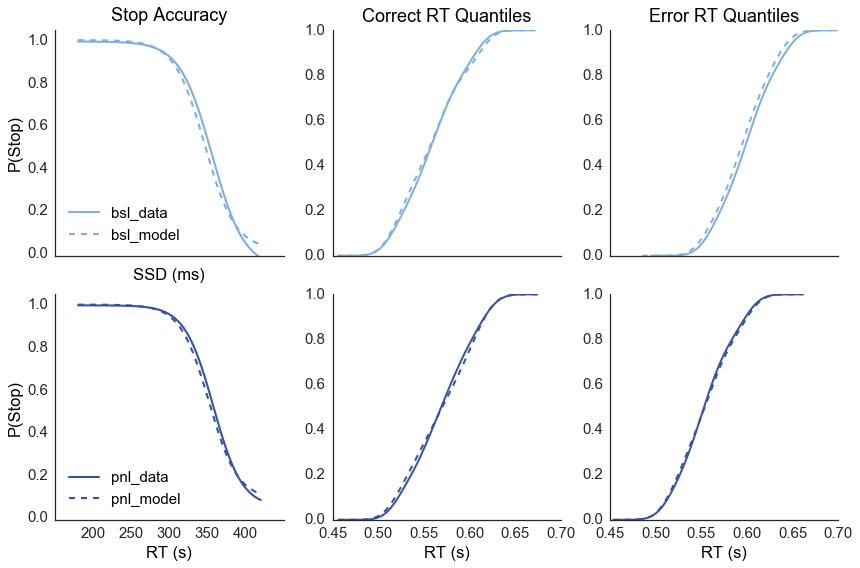

In [30]:
# fit DPM using combination of global (basinhopping + TNC)
# and local gradient optimization (Nelder-Mead Simplex)

# this step can take a while, depending largely on values of nsamples, ninits, nsuccess, and tol
# in basinparams dictionary (modify using <model>.set_basinparams() as in cell above)

# set plot_fits to visualize model predictions overlaid on empirical data
# set progress to get updates of global and local min while basinhopping

dpm.optimize(plot_fits=True, progress=True)#, saveplot=False)

## Examine fits
* yhatDF : pandas dataframe with model-predicted values (same header as observedDF shown above)
* fitDF : pandas dataframe with optimal parameter values and various fit statistics (AIC, BIC, etc)
* txt summary of the fit results are also saved to the working dir 

In [31]:
dpm.yhatDF

,idx,Cond,acc,200,250,300,350,400,c10,c30,c50,c70,c90,e10,e30,e50,e70,e90
0,average,bsl,0.98160,1.0,1.0000,0.916,0.4675,0.0815,0.515,0.535,0.56,0.575,0.610,0.505,0.530,0.545,0.56,0.585
1,average,pnl,0.95825,1.0,0.9995,0.947,0.5690,0.1540,0.520,0.545,0.57,0.595,0.615,0.515,0.535,0.555,0.57,0.600


In [32]:
# uncomment to save yhatDF as csv file in homedir (not available if in binder)
# dpm.yhatDF.to_csv("~/dpm_yhat.csv", index=False)

# to get yhat values...
dpm.yhatDF.loc[:, 'acc':].values

array([[ 0.9816 ,  1.     ,  1.     ,  0.916  ,  0.4675 ,  0.0815 ,
         0.515  ,  0.535  ,  0.56   ,  0.575  ,  0.61   ,  0.505  ,
         0.53   ,  0.545  ,  0.56   ,  0.585  ],
       [ 0.95825,  1.     ,  0.9995 ,  0.947  ,  0.569  ,  0.154  ,
         0.52   ,  0.545  ,  0.57   ,  0.595  ,  0.615  ,  0.515  ,
         0.535  ,  0.555  ,  0.57   ,  0.6    ]])

In [33]:
# the fit summary (goodness of fit measures, etc.) 
dpm.fitDF

idx,average
a,0.57883
ssv,-1.3287
tr,0.065
xb,1.2737
v_bsl,0.96346
v_pnl,0.92847
nfev,76
nvary,2
df,30
chi,0.0034332


In [34]:
# uncomment to save yhatDF as csv file in homedir (not available if in binder)
# dpm.fitDF.to_csv("~/dpm_fit_info.csv", index=False)

In [35]:
# best-fit parameter estimates also stored in popt dictionary
dpm.popt

{'a': 0.57882746860414147,
 'ssv': -1.3287494144338394,
 'tr': 0.065000003809960766,
 'v': array([ 0.96346,  0.92847]),
 'v_bsl': 0.96345943975783732,
 'v_pnl': 0.92846805812849342,
 'xb': 1.2736837457957861}

In [16]:
import radd
radd.style_notebook()

Notebook Theme: Grade3
more at github.com/dunovank/jupyter-themes
